In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.metrics import log_loss, zero_one_loss, mean_squared_error, roc_curve

%matplotlib inline

## Preprocessing (adapted from tool.py)

In [2]:
path = "./data/"

raw_data = pd.read_csv(path + "/TADPOLE_InputData.csv", parse_dates=[1],low_memory=False)
raw_data = raw_data.rename(columns = {'DX':'DX2'}) # Rename that column so there is no conflict in the algorithm

"""Obtain the IDs used for validation and test set"""
yTr_raw = pd.read_csv(path + "/TADPOLE_TargetData_train.csv", parse_dates=[0], low_memory=False)
yVal_raw = pd.read_csv(path + "/TADPOLE_TargetData_test.csv", parse_dates=[0], low_memory=False)
yTe_raw = pd.read_csv(path + "/TADPOLE_PredictTargetData_valid.csv", parse_dates=[0], low_memory=False)

val_id = yVal_raw["PTID_Key"].unique().astype("int")
test_id = yTe_raw["PTID_Key"].unique().astype("int")

"""Columns 1888,1889, 1890 are numbers. Some number have inequality and some are wrongly typed as string
 The following lines convert everything to float and replace inqualities with NaN"""
raw_data.iloc[:,1888] = pd.to_numeric(raw_data.iloc[:,1888],errors = "coerce")
raw_data.iloc[:,1889] = pd.to_numeric(raw_data.iloc[:,1889],errors = "coerce")
raw_data.iloc[:,1890] = pd.to_numeric(raw_data.iloc[:,1890],errors = "coerce")
raw_data.iloc[:,3] = raw_data.iloc[:,3].astype('category')
raw_data.iloc[:,6] = raw_data.iloc[:,6].astype('category')
raw_data.iloc[:,10] = raw_data.iloc[:,10].astype('category')

""" Column 1891 is mixture of string and number. Get rid of the string """
raw_data.iloc[:,1891] = raw_data.iloc[:,1891].str.extract('(\d+)', expand = False)
raw_data.iloc[:,1891] = pd.to_numeric(raw_data.iloc[:,1891])

In [3]:
"""Remove Columns that does not need one-hot encoding"""
n_row, n_col = raw_data.shape

removed_col = [] 
for n in range(n_col):
    if ("PTID_Key" in raw_data.columns[n] or
        "EXAMDATE" in raw_data.columns[n] or 
        "VERSION" in raw_data.columns[n] or 
        "update" in raw_data.columns[n] or 
        "RUNDATE" in raw_data.columns[n] or 
        "STATUS" in raw_data.columns[n] or 
        "BATCH_UPENNBIOMK9_04_19_17" in raw_data.columns[n] or 
        "KIT_UPENNBIOMK9_04_19_17" in raw_data.columns[n] or 
        "STDS_UPENNBIOMK9_04_19_17" in raw_data.columns[n]) :
        
        removed_col += [n]    

col_indices_onehot = np.setxor1d(removed_col,np.arange(n_col))
data_onehot = raw_data.iloc[:, col_indices_onehot]

"""Search for categorical columns and convert to int encoding"""
obj_columns = data_onehot.select_dtypes(['object']).columns
for obj_col in obj_columns:
    data_onehot[obj_col].astype('category')
    
"""Search for categorical columns and convert to int encoding"""
cat_columns = data_onehot.select_dtypes(['category']).columns
data_onehot[cat_columns] = data_onehot[cat_columns].apply(lambda x: x.cat.codes)
        
# """One-hot encode"""
# _nan_categories = data_onehot.isnull()
# data_onehot = pd.get_dummies(data_onehot)

# # Put NaN for the categorical data
# for name in categorical_col:
#     data_onehot.loc[_nan_categories[name], data_onehot.columns.str.startswith(name)] = np.NaN


"""Replace -4 with NaN"""
data_onehot = data_onehot.replace(-4, np.NaN)

#Make it look pretty :) 
data_onehot = data_onehot.replace(np.nan,np.NaN)
data_onehot = data_onehot.replace(np.NAN,np.NaN)

data_onehot = data_onehot.select_dtypes(exclude=[object])

/nfs01/shared_software/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [4]:
data_onehot.head()

,DXCHANGE,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,...,AD_TAP_R_DTIROI_04_30_14,AD_SUMGCC_DTIROI_04_30_14,AD_SUMBCC_DTIROI_04_30_14,AD_SUMSCC_DTIROI_04_30_14,AD_SUMCC_DTIROI_04_30_14,AD_SUMFX_DTIROI_04_30_14,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17
0,0,74.3,11,0,1.36926,NaN,NaN,0.0,10.67,18.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,81.3,13,1,1.09079,NaN,NaN,4.5,22.00,31.00,...,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,NaN
2,2,81.3,13,1,1.06360,NaN,NaN,6.0,19.00,30.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,81.3,13,1,1.10384,NaN,NaN,3.5,24.00,35.00,...,NaN,NaN,NaN,NaN,NaN,NaN,601.4,251.7,24.18,NaN
4,2,81.3,13,1,1.03871,NaN,NaN,8.0,25.67,37.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# drop columns that have >0.7 NaN. 
# Imputing these features with mean/median contaminates the forest too much
data_onehot.dropna(thresh=len(data_onehot)*0.3, axis=1, inplace=True)

In [6]:
data_onehot.head()

,DXCHANGE,AGE,PTEDUCAT,APOE4,FDG,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,...,ST98CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST9SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,LONIUID_BAIPETNMRC_09_12_16
0,0,74.3,11,0,1.36926,0.0,10.67,18.67,28.0,44.0,...,3835.0,1622.0,2.077,0.746,15683.0,4272.0,3.028,0.649,4396.0,26812.0
1,2,81.3,13,1,1.09079,4.5,22.00,31.00,20.0,22.0,...,3681.0,1734.0,1.942,0.696,10387.0,3316.0,2.545,0.686,3304.0,26854.0
2,2,81.3,13,1,1.06360,6.0,19.00,30.00,24.0,19.0,...,4060.0,1868.0,2.051,0.723,9311.0,3138.0,2.445,0.713,3173.0,26850.0
3,2,81.3,13,1,1.10384,3.5,24.00,35.00,17.0,31.0,...,3921.0,1898.0,1.969,0.739,9736.0,3240.0,2.502,0.685,3235.0,26827.0
4,2,81.3,13,1,1.03871,8.0,25.67,37.67,19.0,23.0,...,4129.0,1915.0,2.020,0.707,9316.0,3097.0,2.474,0.677,3314.0,73011.0


In [7]:
# Create our imputer to replace missing values with the mean e.g.
data_onehot_imputed = Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(data_onehot)

#convert ndarray back to dataframe
data_onehot_imputed = pd.DataFrame(data_onehot_imputed, columns = data_onehot.columns)

In [8]:
np.any(data_onehot_imputed==np.NaN)

False

In [9]:
"""
    Only take the most recent visit for each patient. 
    Separate Train, Val, Test
"""
data = pd.concat([data_onehot_imputed, raw_data[['PTID_Key','EXAMDATE']]], axis=1)
data_mostrecent = data.sort_values(['PTID_Key','EXAMDATE'],ascending=False).groupby('PTID_Key').head(1)

In [10]:
""" Preprocess the Target data for Tr, Val.
    predicting the diag variable is classification, 
    predicting the 3 quantitative/continuous variables each is a regression. 
    
    For each patient, look at all his target data entries from different times. 
    
    [Diagnostic variable] "Diag"
    Consider the 3 categories to be AD->1, MCI->0, CN-> -1
    - if any visit is Diag_AD, then label = 1
    - else if any visit is Diag_MCI, then label = 0
    - else assign label = -1
    
    [quantitative variable] "MMSE","Ventricles_Norm", "ADAS13"
    for all 3 variables, ignore NaN and take average if the patient has several target data entries available
"""

yTr = yTr_raw.groupby("PTID_Key").apply(lambda x: x.mean(skipna=True)).reset_index(drop=True)
yTr["Diag"] = yTr.apply(lambda row: 1 if row["AD_Diag"] > 0 else (0 if row["MCI_Diag"] > 0 else -1), axis=1)

yVal = yVal_raw.groupby("PTID_Key").apply(lambda x: x.mean(skipna=True)).reset_index(drop=True)
yVal["Diag"] = yVal.apply(lambda row: 1 if row["AD_Diag"] > 0 else (0 if row["MCI_Diag"] > 0 else -1), axis=1)

In [11]:
Train = pd.merge(yTr, data_mostrecent, how='inner', on=['PTID_Key'])
Validation = pd.merge(yVal, data_mostrecent, how='inner', on=['PTID_Key'])

Train.head()

,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13_x,Ventricles_Norm,MMSE_x,Diag,DXCHANGE,AGE,...,ST98SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST9SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,LONIUID_BAIPETNMRC_09_12_16,EXAMDATE
0,6.0,1.0,0.0,0.0,2.000000,NaN,29.666667,-1,0.0,70.4,...,1651.000000,2.151000,0.748000,12557.000000,3684.000000,2.857000,0.639000,1529.000000,192993.000000,9/2/10
1,8.0,0.0,1.0,0.0,5.000000,0.012128,30.000000,0,0.0,71.4,...,1504.000000,2.421000,0.560000,8950.000000,2661.000000,2.820000,0.643000,1138.000000,165472.284842,6/20/12
2,18.0,0.0,1.0,0.0,11.666667,0.020526,29.666667,0,-1.0,73.0,...,1653.766381,2.245012,0.738751,10021.936654,3135.000467,2.666136,0.696469,2100.075175,165472.284842,8/6/12
3,21.0,0.0,1.0,0.0,9.200000,0.006712,28.000000,0,-1.0,55.0,...,1908.000000,2.341000,0.931000,15998.000000,4388.000000,2.881000,0.910000,1838.000000,165472.284842,12/20/12
4,22.0,0.0,1.0,0.0,15.000000,0.034189,27.200000,0,1.0,75.6,...,1796.000000,2.542000,0.710000,11780.000000,3360.000000,2.949000,0.649000,3306.000000,337071.000000,8/20/12


## Baseline: Random Forest

Random Forest consists of a set of decision trees where each tree consists of split nodes and leaf nodes. The split nodes evaluate each arriving sample and depending on the features of the sample, pass it to the left or right child. Each leaf node stores the statistic of the sample that arrives. The training stage of RF is to construct such multiple decision trees.

The best split function can be learned by searching a pair of optimal splitting parameters w and t that can maximize the purity

In [12]:
X_colnames = Train.iloc[:, 8:].select_dtypes(exclude=[object]).columns
X_colnames = [cn for cn in X_colnames if cn not in ["pred_ADAS13","pred_Ventricles_Norm","pred_MMSE"]]
# Train_colnames

## 1. Predicting Diag 
This is a multi-class classificaion problem. We use the RandomForestClassifier for it

In [13]:
clf_diag = RandomForestClassifier(n_estimators=300, oob_score=True, criterion='gini', verbose=1, warm_start=True)
clf_diag.fit(Train[X_colnames], Train["Diag"])

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=True, random_state=None,
            verbose=1, warm_start=True)

In [14]:
oob_error = 1 - clf_diag.oob_score_
oob_error

0.22290076335877862

/nfs01/shared_software/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


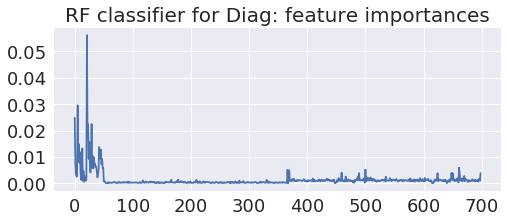

In [15]:
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# print clf_diag.feature_importances_
plt.figure(figsize=(8,3))
plt.plot(clf_diag.feature_importances_)
plt.title("RF classifier for Diag: feature importances", fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [16]:
yTr_pred = Train["PTID_Key"].copy()
# predict class probabilities for Tr and Val
diag_pred_proba = clf_diag.predict_proba(Train[X_colnames])
yTr_pred["Diag"] = clf_diag.predict(Train[X_colnames])
yTr_pred["CN_Diag"] = diag_pred_proba[:,0]
yTr_pred["MCI_Diag"] = diag_pred_proba[:,1]
yTr_pred["AD_Diag"] = diag_pred_proba[:,2]

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [17]:
print("Training error: Log-loss = " +  str(log_loss(Train["Diag"], diag_pred_proba, labels=[-1,0,1])) 
      +"; zero-one-loss = "+  str(zero_one_loss(Train["Diag"], yTr_pred["Diag"])))

Training error: Log-loss = 0.18593176403; zero-one-loss = 0.0


In [18]:
yVal_pred = Validation["PTID_Key"].copy()
# predict class probabilities for Tr and Val
yVal_pred_proba = clf_diag.predict_proba(Validation[X_colnames])
yVal_pred["Diag"] = clf_diag.predict(Validation[X_colnames])
yVal_pred["CN_Diag"] = yVal_pred_proba[:,0]
yVal_pred["MCI_Diag"] = yVal_pred_proba[:,1]
yVal_pred["AD_Diag"] = yVal_pred_proba[:,2]

# yTrue_diag = Train[["CN_Diag","MCI_Diag", "AD_Diag"]].replace(np.NaN, 0)
print("Validation error: Log-loss = " +  str(log_loss(Validation["Diag"], yVal_pred_proba, labels=[-1,0,1])) 
      +"; zero-one-loss = "+  str(zero_one_loss(Validation["Diag"], yVal_pred["Diag"])))

Validation error: Log-loss = 0.705857242746; zero-one-loss = 0.247706422018


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


## 2.  Predicting the 3 quantitative/continuous variables 
Each is a regression problem. 
Although we know a priori that the 3 are very correlated, RF is not good at multi-output, so we have to make 3 RF Regressors. 


## 2.1 Regression for "ADAS13"

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   32.0s finished
/nfs01/shared_software/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


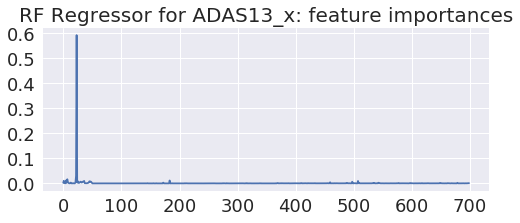

In [19]:
clf_adas13 = RandomForestRegressor(n_estimators=300, oob_score=True, criterion='mse', verbose=1, warm_start=True, random_state=0)

# re-select training data. 
Train_adas13_rows = pd.notnull(Train["ADAS13_x"])
clf_adas13.fit(Train[X_colnames][Train_adas13_rows], Train["ADAS13_x"][Train_adas13_rows])

plt.figure(figsize=(8,3))
plt.plot(clf_adas13.feature_importances_)
plt.title("RF Regressor for ADAS13_x: feature importances", fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [20]:
# predict for Tr 
Train["pred_ADAS13"] = clf_adas13.predict(Train[X_colnames])
print("Training MSE = " +  str(mean_squared_error(Train["ADAS13_x"][Train_adas13_rows], Train["pred_ADAS13"][Train_adas13_rows])))

# predict for Val
valid_rows = pd.notnull(Validation["ADAS13_x"])
Validation["pred_ADAS13"] = clf_adas13.predict(Validation[X_colnames])
print("\nValidation MSE = " +  str(mean_squared_error(Validation["ADAS13_x"][valid_rows], Validation["pred_ADAS13"][valid_rows])))

Training MSE = 6.4906248237

Validation MSE = 47.9836126122


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


## 2.2 Regression for "Ventricles_Norm"

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   20.7s finished
/nfs01/shared_software/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


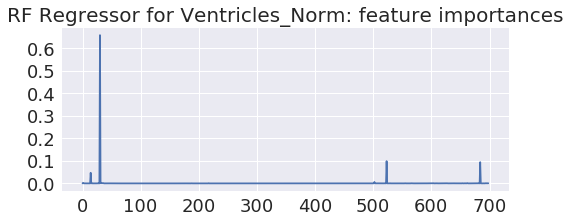

In [21]:
reg_ven = RandomForestRegressor(n_estimators=300, oob_score=True, criterion='mse', verbose=1, warm_start=True, random_state=0)

# re-select training data. 
Train_ven_rows = pd.notnull(Train["Ventricles_Norm"])
reg_ven.fit(Train[X_colnames][Train_ven_rows], Train["Ventricles_Norm"][Train_ven_rows])

plt.figure(figsize=(8,3))
plt.plot(reg_ven.feature_importances_)
plt.title("RF Regressor for Ventricles_Norm: feature importances", fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [22]:
# predict for Tr 
Train["pred_Ventricles_Norm"] = reg_ven.predict(Train[X_colnames])
print("Training MSE = " +  str(mean_squared_error(Train["Ventricles_Norm"][Train_ven_rows], 
                                                  Train["pred_Ventricles_Norm"][Train_ven_rows])))

# predict for Val
valid_rows = pd.notnull(Validation["Ventricles_Norm"])
Validation["pred_Ventricles_Norm"] = reg_ven.predict(Validation[X_colnames])
print("\nValidation MSE = " +  str(mean_squared_error(Validation["Ventricles_Norm"][valid_rows], 
                                                      Validation["pred_Ventricles_Norm"][valid_rows])))

Training MSE = 2.01138904702e-06

Validation MSE = 1.5001310572e-05


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


## 2.3 Regression for "MMSE"

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.6s finished
/nfs01/shared_software/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


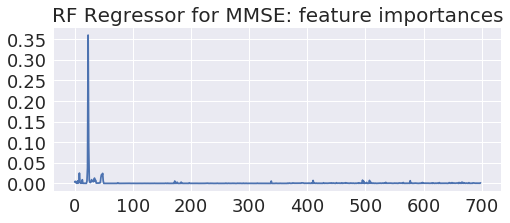

In [23]:
reg_mmse = RandomForestRegressor(n_estimators=300, oob_score=True, criterion='mse', verbose=1, warm_start=True, random_state=0)

# re-select training data. 
Train_mmse_rows = pd.notnull(Train["MMSE_x"])
reg_mmse.fit(Train[X_colnames][Train_adas13_rows], Train["MMSE_x"][Train_mmse_rows])

plt.figure(figsize=(8,3))
plt.plot(reg_mmse.feature_importances_)
plt.title("RF Regressor for MMSE: feature importances", fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [24]:
# predict for Tr 
Train["pred_MMSE"] = reg_mmse.predict(Train[X_colnames])
print("Training MSE = " +  str(mean_squared_error(Train["MMSE_x"][Train_adas13_rows], 
                                                  Train["pred_MMSE"][Train_adas13_rows])))

# predict for Val
valid_rows = pd.notnull(Validation["MMSE_x"])
Validation["pred_MMSE"] = reg_mmse.predict(Validation[X_colnames])
print("\nValidation MSE = " +  str(mean_squared_error(Validation["MMSE_x"][valid_rows], 
                                                      Validation["pred_MMSE"][valid_rows])))

Training MSE = 0.905147861046

Validation MSE = 7.19551080964


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
